In [ ]:
!python -m pip install --upgrade pip
!pip install openvino-dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for openvino-dev from https://files.pythonhosted.org/packages/ad/41/f6fd676dd043ab5ac82ff0f2d1dc8467bc0d4c5d6d6b36fe95771bd2e60d/openvino_dev-2023.0.1-11005-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.2 MB/s eta 0:00:00
  Obtaining dependency information for openvino-telemetry>=2022.1.0 from https://files.pythonhosted.org/packages/79/eb/60cda9b024380ce12ffd9d9f90b9fff38fbd4ca88f37877a2b9aebe9fde1/openvino_telemetry-2023.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for openvino==2023.0.1 from https://files.pythonhosted.org/packages/84/0c/4860207577c016eb1fdf9f1edd025e98706a5b914fa8e41f2de957b68672/openvino-2023.0.1-11005-cp310-cp310-

In [ ]:
!git clone --depth=1 https://github.com/openvinotoolkit/openvino_notebooks.git

Cloning into 'openvino_notebooks'...
remote: Enumerating objects: 444, done.
remote: Counting objects: 100% (444/444), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 444 (delta 26), reused 259 (delta 12), pack-reused 0
Receiving objects: 100% (444/444), 67.58 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
from collections import namedtuple
from itertools import groupby
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

In [ ]:
# Directories where data will be placed.
model_folder = "model"
data_folder = "../data"
charlist_folder = f"{data_folder}/text"

# Precision used by the model.
precision = "FP16"

In [ ]:
Language = namedtuple(
    typename="Language", field_names=["model_name", "charlist_name", "demo_image_name"]
)
chinese_files = Language(
    model_name="handwritten-simplified-chinese-recognition-0001",
    charlist_name="chinese_charlist.txt",
    demo_image_name="handwritten_chinese_test.jpg",
)
japanese_files = Language(
    model_name="handwritten-japanese-recognition-0001",
    charlist_name="japanese_charlist.txt",
    demo_image_name="handwritten_japanese_test.png",
)

In [ ]:
# Select the language by using either language="chinese" or language="japanese".
language = "chinese"

languages = {"chinese": chinese_files, "japanese": japanese_files}

selected_language = languages.get(language)
print(selected_language)

Language(model_name='handwritten-simplified-chinese-recognition-0001', charlist_name='chinese_charlist.txt', demo_image_name='handwritten_chinese_test.jpg')


# Download model


In [ ]:
path_to_model_weights = Path(f'{model_folder}/intel/{selected_language.model_name}/{precision}/{selected_language.model_name}.bin')
if not path_to_model_weights.is_file():
    download_command = f'omz_downloader --name {selected_language.model_name} --output_dir {model_folder} --precision {precision}'
    print(download_command)
    ! $download_command

omz_downloader --name handwritten-simplified-chinese-recognition-0001 --output_dir model --precision FP16
################|| Downloading handwritten-simplified-chinese-recognition-0001 ||################

========== Downloading model/intel/handwritten-simplified-chinese-recognition-0001/FP16/handwritten-simplified-chinese-recognition-0001.xml
... 100%, 107 KB, 458 KB/s, 0 seconds passed

========== Downloading model/intel/handwritten-simplified-chinese-recognition-0001/FP16/handwritten-simplified-chinese-recognition-0001.bin
... 100%, 33726 KB, 18514 KB/s, 1 seconds passed



# Load model

In [ ]:
ie = Core()
path_to_model = path_to_model_weights.with_suffix(".xml")
model = ie.read_model(path_to_model)

In [ ]:
# To check available device names run the line below
# print(ie.available_devices)

compiled_model = ie.compile_model(model=model, device_name="CPU")

In [ ]:
recognition_output_layer = compiled_model.output(0)
recognition_input_layer = compiled_model.input(0)

# Prepare Charlist

In [ ]:
# Get a dictionary to encode the output, based on model documentation.
# IMPORTANT: Need to import used charlist
used_charlist = '/content/chinese_charlist.txt' # path to charlist

# With both models, there should be blank symbol added at index 0 of each charlist.
blank_char = "~"

with open(used_charlist, "r", encoding="utf-8") as charlist:
    letters = blank_char + "".join(line.strip() for line in charlist)

# Load image

In [ ]:
# Read a filename of a demo file based on the selected model.
file_name = selected_language.demo_image_name

# text detection models expect an image in grayscale format.
# read one line at time

# Read the image
image = cv2.imread("/content/sam6.png",
                   flags=cv2.IMREAD_GRAYSCALE)

# Fetch the shape
image_height,_ = image.shape

# B,C,H,W = batch size, number of channels, height, width.
_, _, H, W = recognition_input_layer.shape

# Calculate scale ratio between the input shape height and image height to resize the image.
scale_ratio = H / image_height

# Resize the image to expected input sizes.
resized_image = cv2.resize(
    image, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA
)

# Pad the image to match input size, without changing aspect ratio.
resized_image = np.pad(
    resized_image, ((0, 0), (0, W - resized_image.shape[1])), mode="edge"
)

# Reshape to network input shape.
input_image = resized_image[None, None, :, :]

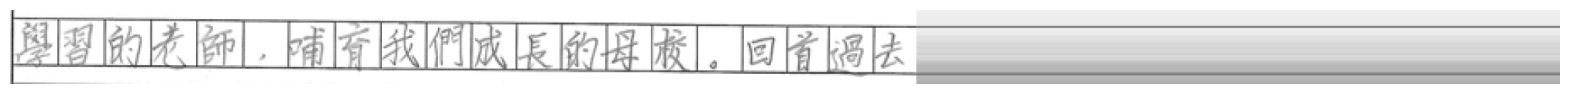

In [ ]:
plt.figure(figsize=(20, 1))
plt.axis("off")
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=255);

# Run inference

In [ ]:
# Run inference on the model
# output W x B x L
# W - output sequence length
# B - batch size
# L - confidence distribution
predictions = compiled_model([input_image])[recognition_output_layer]
predictions.shape

(186, 1, 4059)

In [ ]:
# Remove a batch dimension.
predictions = np.squeeze(predictions)

# Run the `argmax` function to pick the symbols with the highest probability.
predictions_indexes = np.argmax(predictions, axis=1)
print(predictions_indexes)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 3641    0 2546    0
 3726    0 3341    0 3664    0    0  912    0 2497    0  585    0 2511
    0 3641 2354    0  404    0 2821    0 3815    0  665  857    0 2926
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [ ]:
# Use the `groupby` function to remove concurrent letters, as required by CTC greedy decoding.
output_text_indexes = list(groupby(predictions_indexes))

# Remove grouper objects.
output_text_indexes, _ = np.transpose(output_text_indexes, (1, 0))

# Remove blank symbols.
output_text_indexes = output_text_indexes[output_text_indexes != 0]

# Assign letters to indexes from the output array.
output_text = [letters[letter_index] for letter_index in output_text_indexes]

# Print output

的老市，哺我们成是的母校。回首遇去


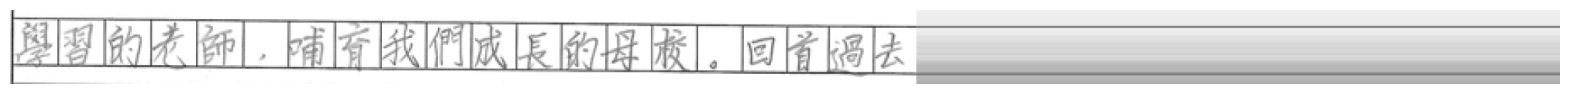

In [ ]:
plt.figure(figsize=(20, 1))
plt.axis("off")
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=255)

print("".join(output_text))